In [30]:
from datetime import * 
import time
import numpy as np 
import pandas as pd
import requests
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt 
import talib
import json 
import ccxt
from tqdm import tqdm
import seaborn as sns

In [36]:
import json

with open('ByBit_BTCUSDT.json') as f:
    d = json.load(f)


In [37]:
df = pd.DataFrame(d)
df.head()

,0,1,2,3,4,5
0,1585130400000,6500.0,6591.5,6500.0,6591.5,0.004
1,1585134000000,6591.5,6628.5,6457.5,6511.5,438.873
2,1585137600000,6511.5,6588.5,6502.0,6583.5,529.318
3,1585141200000,6583.5,6745.5,6562.0,6585.0,449.162
4,1585144800000,6585.0,6640.0,6516.0,6590.0,258.831


In [38]:
df = df.rename(columns={0:"timestamp",
                        1:"open",
                        2:"high",
                        3:"low",
                        4:"close",
                        5:"volume"})

df.head(3)

,timestamp,open,high,low,close,volume
0,1585130400000,6500.0,6591.5,6500.0,6591.5,0.004
1,1585134000000,6591.5,6628.5,6457.5,6511.5,438.873
2,1585137600000,6511.5,6588.5,6502.0,6583.5,529.318


In [39]:
def process(df): 
    bybit = ccxt.bybit() 
    dates = df['timestamp'].values 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = bybit.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df['datetime'] = timestamp 
    df = df.drop(columns={'timestamp'})
    return df

df = process(df)

In [40]:
hours = []
days = [] 
months = [] 
years = [] 
for dt in tqdm(df['datetime']):
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    year = pd.to_datetime(dt).year 
    hours.append(hour) 
    days.append(day) 
    months.append(month)
    years.append(year) 

df['Hours'] = hours
df['Days'] = days 
df['Months'] = months 
df['Years'] = years 

df.head(3)

100%|██████████| 16870/16870 [00:08<00:00, 2069.55it/s]


,open,high,low,close,volume,datetime,Hours,Days,Months,Years
0,6500.0,6591.5,6500.0,6591.5,0.004,2020-03-25 10:00:00,10,25,3,2020
1,6591.5,6628.5,6457.5,6511.5,438.873,2020-03-25 11:00:00,11,25,3,2020
2,6511.5,6588.5,6502.0,6583.5,529.318,2020-03-25 12:00:00,12,25,3,2020


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

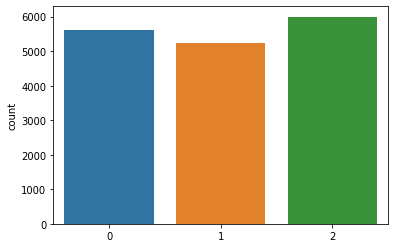

In [41]:
targets = [] 
close = df['close'].values
# 0: long, 1: short, 2: hold 
for i in range(len(close)-1):
    ret = (close[i+1] - close[i]) / close[i] 
    if ret > -0.002 and ret < 0.002:
        targets.append(2) 
    elif ret <= -0.002:
        targets.append(1) 
    elif ret >= 0.002: 
        targets.append(0) 
        
sns.countplot(targets)

In [42]:
targets.append(None) 

df['target'] = targets 

df.head(3)

,open,high,low,close,volume,datetime,Hours,Days,Months,Years,target
0,6500.0,6591.5,6500.0,6591.5,0.004,2020-03-25 10:00:00,10,25,3,2020,1.0
1,6591.5,6628.5,6457.5,6511.5,438.873,2020-03-25 11:00:00,11,25,3,2020,0.0
2,6511.5,6588.5,6502.0,6583.5,529.318,2020-03-25 12:00:00,12,25,3,2020,2.0


In [43]:
df = df.dropna() 

train_df = df[df['Years'] != 2022] 
test_df = df[df['Years'] == 2022] 

train_size = int(train_df.shape[0] * 0.9) 
val_df = train_df.iloc[train_size:, :] 
train_df = train_df.iloc[:train_size,:] 


train_df.shape, val_df.shape, test_df.shape

((13966, 11), (1552, 11), (1351, 11))

In [44]:
train_df = train_df.drop(columns={'datetime','Years'}) 
val_df = val_df.drop(columns={'datetime', 'Years'}) 
test_df = test_df.drop(columns={'datetime', 'Years'})

In [47]:
input_features = []
for col in train_df.columns:
    if col != 'target':
        input_features.append(col) 
        
X_train = train_df[input_features].values
Y_train = train_df['target'].values 
Y_train = Y_train.reshape((-1,1))

X_val = val_df[input_features].values
Y_val = val_df['target'].values 
Y_val = Y_val.reshape((-1,1))

X_test = test_df[input_features].values
Y_test = test_df['target'].values 
Y_test = Y_test.reshape((-1,1))

In [51]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier 

clf = TabNetMultiTaskClassifier() 

clf.fit(
    X_train, Y_train, 
    eval_set=[(X_val, Y_val)], 
    eval_metric = ['accuracy', 'balanced_accuracy'],
    max_epochs = 500, 
    patience = 100 
)


Device used : cuda
epoch 0  | loss: 1.15189 | val_0_accuracy: 0.3183  | val_0_balanced_accuracy: 0.31578 |  0:00:01s
epoch 1  | loss: 1.0684  | val_0_accuracy: 0.3357  | val_0_balanced_accuracy: 0.33589 |  0:00:02s
epoch 2  | loss: 1.06152 | val_0_accuracy: 0.34278 | val_0_balanced_accuracy: 0.32792 |  0:00:03s
epoch 3  | loss: 1.05985 | val_0_accuracy: 0.34987 | val_0_balanced_accuracy: 0.34691 |  0:00:04s
epoch 4  | loss: 1.05761 | val_0_accuracy: 0.32861 | val_0_balanced_accuracy: 0.32581 |  0:00:05s
epoch 5  | loss: 1.05554 | val_0_accuracy: 0.35374 | val_0_balanced_accuracy: 0.34288 |  0:00:06s
epoch 6  | loss: 1.05405 | val_0_accuracy: 0.35438 | val_0_balanced_accuracy: 0.35081 |  0:00:07s
epoch 7  | loss: 1.05335 | val_0_accuracy: 0.34665 | val_0_balanced_accuracy: 0.34371 |  0:00:08s
epoch 8  | loss: 1.05353 | val_0_accuracy: 0.34665 | val_0_balanced_accuracy: 0.34353 |  0:00:09s
epoch 9  | loss: 1.05077 | val_0_accuracy: 0.35374 | val_0_balanced_accuracy: 0.34352 |  0:00:10s
e

epoch 84 | loss: 1.03861 | val_0_accuracy: 0.34794 | val_0_balanced_accuracy: 0.35546 |  0:01:20s
epoch 85 | loss: 1.04026 | val_0_accuracy: 0.34665 | val_0_balanced_accuracy: 0.35408 |  0:01:21s
epoch 86 | loss: 1.03909 | val_0_accuracy: 0.33892 | val_0_balanced_accuracy: 0.34608 |  0:01:22s
epoch 87 | loss: 1.04006 | val_0_accuracy: 0.34987 | val_0_balanced_accuracy: 0.35736 |  0:01:23s
epoch 88 | loss: 1.03922 | val_0_accuracy: 0.34858 | val_0_balanced_accuracy: 0.356   |  0:01:24s
epoch 89 | loss: 1.0387  | val_0_accuracy: 0.35374 | val_0_balanced_accuracy: 0.36139 |  0:01:25s
epoch 90 | loss: 1.03854 | val_0_accuracy: 0.35309 | val_0_balanced_accuracy: 0.36078 |  0:01:25s
epoch 91 | loss: 1.03936 | val_0_accuracy: 0.35309 | val_0_balanced_accuracy: 0.36074 |  0:01:26s
epoch 92 | loss: 1.03911 | val_0_accuracy: 0.36534 | val_0_balanced_accuracy: 0.37142 |  0:01:27s
epoch 93 | loss: 1.03816 | val_0_accuracy: 0.36985 | val_0_balanced_accuracy: 0.36662 |  0:01:28s
epoch 94 | loss: 1.0

In [68]:
prediction = clf.predict(X_test)[0]
cnt = 0 
for i in range(len(Y_test)):
    if float(prediction[i]) == Y_test[i]:
        cnt += 1 
        
print(cnt / len(prediction) * 100)     

35.01110288675056


# With Feature Engineering 

In [230]:
with open('ByBit_BTCUSDT.json') as f:
    d = json.load(f)
df = pd.DataFrame(d)
df = df.rename(columns={0:"timestamp",
                        1:"open",
                        2:"high",
                        3:"low",
                        4:"close",
                        5:"volume"})
df = process(df)

hours = []
days = [] 
months = [] 
years = [] 
for dt in tqdm(df['datetime'], position=0, leave=True):
    dtobj = pd.to_datetime(dt)
    hour = dtobj.hour 
    day = dtobj.day 
    month = dtobj.month 
    year = dtobj.year 
    hours.append(hour) 
    days.append(day) 
    months.append(month)
    years.append(year) 

df['Hours'] = hours
df['Days'] = days 
df['Months'] = months 
df['Years'] = years 

targets = [] 
close = df['close'].values
# 0: long, 1: short, 2: hold 
threshold = 0.002
for i in range(len(close)-1):
    ret = (close[i+1] - close[i]) / close[i] 
    if ret > -threshold and ret < threshold:
        targets.append(2) 
    elif ret <= -threshold:
        targets.append(1) 
    elif ret >= threshold: 
        targets.append(0) 
        
targets.append(None) 
df['target'] = targets 

df.head(3)

100%|██████████| 16870/16870 [00:02<00:00, 7646.11it/s]


,open,high,low,close,volume,datetime,Hours,Days,Months,Years,target
0,6500.0,6591.5,6500.0,6591.5,0.004,2020-03-25 10:00:00,10,25,3,2020,1.0
1,6591.5,6628.5,6457.5,6511.5,438.873,2020-03-25 11:00:00,11,25,3,2020,0.0
2,6511.5,6588.5,6502.0,6583.5,529.318,2020-03-25 12:00:00,12,25,3,2020,2.0


In [231]:
df.set_index(pd.DatetimeIndex(df['datetime']), inplace=True)
df = df.drop(columns={'datetime'})
df.head(3)

,open,high,low,close,volume,Hours,Days,Months,Years,target
datetime,,,,,,,,,,
2020-03-25 10:00:00,6500.0,6591.5,6500.0,6591.5,0.004,10,25,3,2020,1.0
2020-03-25 11:00:00,6591.5,6628.5,6457.5,6511.5,438.873,11,25,3,2020,0.0
2020-03-25 12:00:00,6511.5,6588.5,6502.0,6583.5,529.318,12,25,3,2020,2.0


In [232]:
def differencing(df, lookback=121): 
    columns = ["open", "high", "low", "close", "volume"]
    for col in columns: 
        feature_values = df[col].values  
        d = {} 
        for i in range(1, lookback): 
            d['{}_Differenced_{}'.format(col, i)] = []
        for i in tqdm(range(df.shape[0]), position=0, leave=True): 
            if i < lookback: 
                for j in range(1, lookback): 
                    d['{}_Differenced_{}'.format(col, j)].append(None)
            else: 
                for j in range(1, lookback): 
                    if col == "volume": 
                        if feature_values[i-j] == 0:
                            ret = 1 
                        else:
                            ret = feature_values[i] / feature_values[i-j] 
                    else: 
                        ret = feature_values[i] / feature_values[i-j] 
                    d['{}_Differenced_{}'.format(col, j)].append(ret) 
        for key, value in d.items():
            df[key] = value
    return df 


def feature_engineering(df): 
    # columns to drop 
    drop_cols = []  
    
    print("===== adding technical indicator features =====")
    df.ta.strategy('all') 
    indicators = [] 
    for col in df.columns:
        val = df[col].values 
        nan_cnt = np.sum(np.isnan(val)) 
        if nan_cnt <= 50:
            indicators.append(col)
    df = df[indicators] 


    print("===== differencing =====")
    
    df = differencing(df)  
    
    print(df.shape)
    
    print("===== checking if data is outlier =====")
    is_outlier = [None] 
    close = df['close'].values 
    for i in tqdm(range(1, close.shape[0])):
        ret = (close[i]-close[i-1]) / close[i-1]
        if ret >= 0.01 or ret <= -0.01:
            is_outlier.append(1) 
        else:
            is_outlier.append(0) 
    df['is_outlier'] = is_outlier 
    
    df = df.dropna() 
    df = df.drop(columns={drop_cols[i] for i in range(len(drop_cols))})
    
    return df, indicators

In [233]:
df, indicators = feature_engineering(df) 

===== adding technical indicator features =====


131it [00:13,  9.70it/s]


===== differencing =====


100%|██████████| 16870/16870 [00:01<00:00, 11220.87it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 16870/16870 [00:02<00:00, 7667.88it/s]


(16870, 871)
===== checking if data is outlier =====


100%|██████████| 16869/16869 [00:00<00:00, 955524.39it/s]


In [234]:
df.shape

(16723, 872)

In [235]:
df.head(3)

,open,high,low,close,volume,Hours,Days,Months,Years,target,...,volume_Differenced_112,volume_Differenced_113,volume_Differenced_114,volume_Differenced_115,volume_Differenced_116,volume_Differenced_117,volume_Differenced_118,volume_Differenced_119,volume_Differenced_120,is_outlier
datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-30 11:00:00,6273.0,6386.0,6266.5,6358.5,816.437,11,30,3,2020,1.0,...,75.358778,47.225648,49.412153,35.214018,39.454743,3.154325,1.817689,1.542432,1.860304,1.0
2020-03-30 12:00:00,6358.5,6374.5,6285.0,6302.5,742.262,12,30,3,2020,2.0,...,36.539431,68.512276,42.935099,44.922956,32.014751,35.870198,2.867748,1.652549,1.402299,0.0
2020-03-30 13:00:00,6302.5,6338.5,6297.5,6302.0,575.246,13,30,3,2020,0.0,...,63.739169,28.317712,53.096363,33.274294,34.814864,24.811128,27.799062,2.222477,1.280709,0.0


In [236]:
train_df = df[df['Years'] != 2022] 
test_df = df[df['Years'] == 2022] 

train_size = int(train_df.shape[0] * 0.9) 
val_df = train_df.iloc[train_size:, :] 
train_df = train_df.iloc[:train_size,:] 

train_df.shape, val_df.shape, test_df.shape

((13857, 872), (1540, 872), (1326, 872))

In [237]:
input_features = []
for col in train_df.columns:
    if col != 'target' and col != 'Years':
        input_features.append(col) 
        
X_train = train_df[input_features].values
Y_train = train_df['target'].values 
Y_train = Y_train.reshape((-1,1))

X_val = val_df[input_features].values
Y_val = val_df['target'].values 
Y_val = Y_val.reshape((-1,1))

X_test = test_df[input_features].values
Y_test = test_df['target'].values 
Y_test = Y_test.reshape((-1,1)) 

In [238]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier 

clf = TabNetMultiTaskClassifier() 

clf.fit(
    X_train, Y_train, 
    eval_set=[(X_val, Y_val)], 
    eval_metric = ['accuracy', 'balanced_accuracy'],
    max_epochs = 500, 
    patience = 500 
)

Device used : cuda
epoch 0  | loss: 1.19348 | val_0_accuracy: 0.35455 | val_0_balanced_accuracy: 0.35662 |  0:00:01s
epoch 1  | loss: 1.10886 | val_0_accuracy: 0.33377 | val_0_balanced_accuracy: 0.33792 |  0:00:02s
epoch 2  | loss: 1.09297 | val_0_accuracy: 0.35    | val_0_balanced_accuracy: 0.33292 |  0:00:03s
epoch 3  | loss: 1.07479 | val_0_accuracy: 0.34286 | val_0_balanced_accuracy: 0.35257 |  0:00:05s
epoch 4  | loss: 1.06821 | val_0_accuracy: 0.32662 | val_0_balanced_accuracy: 0.33593 |  0:00:06s
epoch 5  | loss: 1.06459 | val_0_accuracy: 0.32208 | val_0_balanced_accuracy: 0.33053 |  0:00:07s
epoch 6  | loss: 1.05759 | val_0_accuracy: 0.33377 | val_0_balanced_accuracy: 0.34225 |  0:00:09s
epoch 7  | loss: 1.05428 | val_0_accuracy: 0.33896 | val_0_balanced_accuracy: 0.34745 |  0:00:10s
epoch 8  | loss: 1.05201 | val_0_accuracy: 0.33117 | val_0_balanced_accuracy: 0.33932 |  0:00:11s
epoch 9  | loss: 1.05095 | val_0_accuracy: 0.34026 | val_0_balanced_accuracy: 0.34874 |  0:00:12s
e

epoch 84 | loss: 0.95196 | val_0_accuracy: 0.47208 | val_0_balanced_accuracy: 0.47234 |  0:01:33s
epoch 85 | loss: 0.95644 | val_0_accuracy: 0.47078 | val_0_balanced_accuracy: 0.46903 |  0:01:34s
epoch 86 | loss: 0.96047 | val_0_accuracy: 0.47273 | val_0_balanced_accuracy: 0.47141 |  0:01:35s
epoch 87 | loss: 0.95448 | val_0_accuracy: 0.47013 | val_0_balanced_accuracy: 0.47179 |  0:01:36s
epoch 88 | loss: 0.95282 | val_0_accuracy: 0.47273 | val_0_balanced_accuracy: 0.47309 |  0:01:37s
epoch 89 | loss: 0.95292 | val_0_accuracy: 0.48831 | val_0_balanced_accuracy: 0.49057 |  0:01:38s
epoch 90 | loss: 0.95214 | val_0_accuracy: 0.47727 | val_0_balanced_accuracy: 0.47956 |  0:01:39s
epoch 91 | loss: 0.95474 | val_0_accuracy: 0.47922 | val_0_balanced_accuracy: 0.48052 |  0:01:40s
epoch 92 | loss: 0.94707 | val_0_accuracy: 0.47078 | val_0_balanced_accuracy: 0.47319 |  0:01:41s
epoch 93 | loss: 0.96157 | val_0_accuracy: 0.45779 | val_0_balanced_accuracy: 0.46184 |  0:01:42s
epoch 94 | loss: 0.9

epoch 168| loss: 0.9251  | val_0_accuracy: 0.48506 | val_0_balanced_accuracy: 0.48636 |  0:03:02s
epoch 169| loss: 0.92155 | val_0_accuracy: 0.46948 | val_0_balanced_accuracy: 0.47213 |  0:03:03s
epoch 170| loss: 0.95173 | val_0_accuracy: 0.46494 | val_0_balanced_accuracy: 0.46741 |  0:03:04s
epoch 171| loss: 0.9429  | val_0_accuracy: 0.48052 | val_0_balanced_accuracy: 0.48054 |  0:03:05s
epoch 172| loss: 0.9333  | val_0_accuracy: 0.47792 | val_0_balanced_accuracy: 0.47979 |  0:03:06s
epoch 173| loss: 0.9269  | val_0_accuracy: 0.45649 | val_0_balanced_accuracy: 0.46026 |  0:03:07s
epoch 174| loss: 0.92437 | val_0_accuracy: 0.47013 | val_0_balanced_accuracy: 0.47101 |  0:03:08s
epoch 175| loss: 0.92523 | val_0_accuracy: 0.47013 | val_0_balanced_accuracy: 0.47115 |  0:03:09s
epoch 176| loss: 0.92323 | val_0_accuracy: 0.47468 | val_0_balanced_accuracy: 0.47698 |  0:03:10s
epoch 177| loss: 0.91528 | val_0_accuracy: 0.47532 | val_0_balanced_accuracy: 0.47742 |  0:03:11s
epoch 178| loss: 0.9

epoch 252| loss: 0.79443 | val_0_accuracy: 0.44221 | val_0_balanced_accuracy: 0.44555 |  0:04:30s
epoch 253| loss: 0.79665 | val_0_accuracy: 0.44935 | val_0_balanced_accuracy: 0.45135 |  0:04:31s
epoch 254| loss: 0.78754 | val_0_accuracy: 0.45649 | val_0_balanced_accuracy: 0.45825 |  0:04:32s
epoch 255| loss: 0.78574 | val_0_accuracy: 0.45195 | val_0_balanced_accuracy: 0.45393 |  0:04:33s
epoch 256| loss: 0.78187 | val_0_accuracy: 0.44091 | val_0_balanced_accuracy: 0.44444 |  0:04:34s
epoch 257| loss: 0.78587 | val_0_accuracy: 0.44351 | val_0_balanced_accuracy: 0.44564 |  0:04:35s
epoch 258| loss: 0.7863  | val_0_accuracy: 0.43701 | val_0_balanced_accuracy: 0.4402  |  0:04:36s
epoch 259| loss: 0.79406 | val_0_accuracy: 0.4487  | val_0_balanced_accuracy: 0.4498  |  0:04:37s
epoch 260| loss: 0.78228 | val_0_accuracy: 0.44091 | val_0_balanced_accuracy: 0.44295 |  0:04:38s
epoch 261| loss: 0.79437 | val_0_accuracy: 0.45065 | val_0_balanced_accuracy: 0.45284 |  0:04:39s
epoch 262| loss: 0.7

epoch 336| loss: 0.69021 | val_0_accuracy: 0.4487  | val_0_balanced_accuracy: 0.45158 |  0:05:59s
epoch 337| loss: 0.6893  | val_0_accuracy: 0.45584 | val_0_balanced_accuracy: 0.45769 |  0:06:00s
epoch 338| loss: 0.69993 | val_0_accuracy: 0.45974 | val_0_balanced_accuracy: 0.46172 |  0:06:01s
epoch 339| loss: 0.70413 | val_0_accuracy: 0.45195 | val_0_balanced_accuracy: 0.45425 |  0:06:02s
epoch 340| loss: 0.70155 | val_0_accuracy: 0.44481 | val_0_balanced_accuracy: 0.44723 |  0:06:03s
epoch 341| loss: 0.68977 | val_0_accuracy: 0.45649 | val_0_balanced_accuracy: 0.45814 |  0:06:04s
epoch 342| loss: 0.68666 | val_0_accuracy: 0.44351 | val_0_balanced_accuracy: 0.44635 |  0:06:05s
epoch 343| loss: 0.6933  | val_0_accuracy: 0.44481 | val_0_balanced_accuracy: 0.44758 |  0:06:06s
epoch 344| loss: 0.71015 | val_0_accuracy: 0.44805 | val_0_balanced_accuracy: 0.44913 |  0:06:07s
epoch 345| loss: 0.7219  | val_0_accuracy: 0.45779 | val_0_balanced_accuracy: 0.45947 |  0:06:08s
epoch 346| loss: 0.6

epoch 420| loss: 0.66391 | val_0_accuracy: 0.44286 | val_0_balanced_accuracy: 0.44629 |  0:07:26s
epoch 421| loss: 0.65319 | val_0_accuracy: 0.45649 | val_0_balanced_accuracy: 0.45864 |  0:07:27s
epoch 422| loss: 0.65573 | val_0_accuracy: 0.42987 | val_0_balanced_accuracy: 0.4327  |  0:07:28s
epoch 423| loss: 0.67906 | val_0_accuracy: 0.43636 | val_0_balanced_accuracy: 0.44013 |  0:07:29s
epoch 424| loss: 0.65805 | val_0_accuracy: 0.44091 | val_0_balanced_accuracy: 0.44404 |  0:07:31s
epoch 425| loss: 0.64601 | val_0_accuracy: 0.43442 | val_0_balanced_accuracy: 0.43681 |  0:07:32s
epoch 426| loss: 0.63734 | val_0_accuracy: 0.43961 | val_0_balanced_accuracy: 0.44437 |  0:07:33s
epoch 427| loss: 0.63771 | val_0_accuracy: 0.43831 | val_0_balanced_accuracy: 0.44026 |  0:07:34s
epoch 428| loss: 0.64856 | val_0_accuracy: 0.4461  | val_0_balanced_accuracy: 0.44853 |  0:07:35s
epoch 429| loss: 0.65646 | val_0_accuracy: 0.43896 | val_0_balanced_accuracy: 0.44286 |  0:07:36s
epoch 430| loss: 0.6

In [239]:
prediction = clf.predict(X_test)[0]
cnt = 0 
for i in range(len(Y_test)):
    if float(prediction[i]) == Y_test[i]:
        cnt += 1 
        
print(cnt / len(prediction) * 100)     

49.547511312217196


In [240]:
clf.save_model("tabnet_with_technical_indicators.pt") 

Successfully saved model at tabnet_with_technical_indicators.pt.zip


'tabnet_with_technical_indicators.pt.zip'